In [47]:

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split
import random
import glob
import pandas as pd
import keras
import tensorflow_addons as tfa
from tensorflow_addons.rnn.peephole_lstm_cell import PeepholeLSTMCell

from tensorflow.keras.layers import LSTM, Flatten, Dropout, BatchNormalization, LSTMCell
from sklearn.preprocessing import MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class LSTMModel:
    def __init__(self, epochs=50, learning_rate=0.01, is_batch_normalization=True, dropout_rate=0.5,
                 data_path="", preprocess="StandardScaler", num_layers=4, num_cells=16, use_peephole=False,regularization=None):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.is_batch_normalization = is_batch_normalization
        self.dropout_rate = dropout_rate
        self.data_path = data_path
        self.preprocess = preprocess
        self.num_layers = num_layers
        self.num_cells = num_cells
        self.use_peephole = use_peephole
        self.regularization=regularization

    def load_file(self, file_path):
        l = []
        with open(file_path, 'r') as f:
            data = []
            for line in f:
                if '#' in line:
                    continue  # Skip comment lines
                line_data = line.strip().split(',')[1:]
                l.append(line_data)
                numeric_data = [float(x) for x in line_data if x.strip() and x.strip() != '#']
                data.append(numeric_data)

        if data != []:
            data = np.array(data)
            train_x = data[:, :-1]
            train_y = data[:, -1][0]
            return train_x, train_y
        return 0, 0

    def load_data_from_directory(self, directory):
        file_paths = glob.glob(directory + "/**/*.csv")
        random.shuffle(file_paths)
        train_x_list = []
        train_y_list = []
        for file_path in file_paths:
            train_x, train_y = self.load_file(file_path)
            if isinstance(train_x, int):
                continue
            train_x_list.append(train_x)
            train_y_list.append(train_y)
        return np.array(train_x_list), np.array(train_y_list)

    def fetch_data(self, data_dir):
        csv_files = glob.glob(data_dir + "/**/*.csv")
        combined_csv = pd.concat([pd.read_csv(f, header=None) for f in csv_files], ignore_index=True)
        del combined_csv[combined_csv.columns[0]]
        combined_csv = combined_csv[combined_csv.iloc[:, 3] != '#']
        data = combined_csv.values
        data = data.astype(np.float32)
        return data

    def create_model(self):
        model = keras.Sequential()
        for _ in range(self.num_layers):
            kernel_regularizer=None
            if self.regularization!=None and self.regularization>0:
                kernel_regularizer = tf.keras.regularizers.L2(self.regularization)
            lstm_layer=None
            if self.use_peephole:
                cell = tfa.rnn.PeepholeLSTMCell(self.num_cells)
                if _==self.num_layers-1:
                    lstm_layer = tf.keras.layers.RNN(cell)
                else:
                    lstm_layer = tf.keras.layers.RNN(cell, return_sequences=True)
                # lstm_layer = LSTM(self.num_cells, return_sequences=True, implementation=2)
            else:
                if _==self.num_layers-1:
                    lstm_layer = LSTM(self.num_cells, unit_forget_bias=False,
                                kernel_regularizer=kernel_regularizer)
                else:
                    lstm_layer = LSTM(self.num_cells, return_sequences=True, unit_forget_bias=False,
                                kernel_regularizer=kernel_regularizer)
            model.add(lstm_layer)
            if self.dropout_rate > 0:
                model.add(Dropout(self.dropout_rate))
            if self.is_batch_normalization:
                model.add(BatchNormalization())
        model.add(keras.layers.Dense(3, activation='softmax'))

        return model

    def save_model(self, model):
        model.save("LSTM_Model.h5")

    def plot_graphs(self, history):
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs_range = range(self.epochs)
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epochs_range, acc, label='Training Accuracy')
        plt.plot(epochs_range, val_acc, label='Validation Accuracy')
        plt.legend(loc='lower right')
        plt.title('Training and Validation Accuracy')
        plt.subplot(1, 2, 2)
        plt.plot(epochs_range, loss, label='Training Loss')
        plt.plot(epochs_range, val_loss, label='Validation Loss')
        plt.legend(loc='upper right')
        plt.title('Training and Validation Loss')
        plt.show()

    def get_loss_and_accuracy(self, X_test, y_test, model):
        loss, acc = model.evaluate(X_test, y_test)
        print("Test Loss:", loss)
        print("Test Accuracy:", acc)
        # s=model.predict(X_test)
        
        # max_indices = np.argmax(s, axis=1)
        # print(s.shape)
        # print(max_indices)

    def preprocess_data(self, X_train, X_test):
        if self.preprocess == 'StandardScaler':
            scaler = StandardScaler()
        elif self.preprocess == 'MinMaxScaler':
            scaler = MinMaxScaler()
        elif self.preprocess == 'RobustScaler':
            scaler = RobustScaler()
        elif self.preprocess == 'Normalizer':
            scaler = Normalizer()

        X_train_processed = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test_processed = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        return X_train_processed, X_test_processed

    def train(self):
        X_train, y_train = self.load_data_from_directory(self.data_path)
        y_train = y_train.reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
        X_train, X_test = self.preprocess_data(X_train, X_test)

        model = self.create_model()
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=self.learning_rate),
               loss=keras.losses.SparseCategoricalCrossentropy(),  # Use categorical crossentropy for multi-class classification
              metrics=['accuracy'])  # Track accuracy as a metric
        
        print("X_train shape",X_train.shape)
        print("y_train shape",y_train.shape)
        print("X_test shape",X_test.shape)
        print("y_test shape",y_test.shape)
        history = model.fit(X_train, y_train, epochs=self.epochs, batch_size=64,
                            validation_data=(X_test, y_test))
        print(model.summary())

        self.save_model(model)
        self.plot_graphs(history=history)
        self.get_loss_and_accuracy(X_test, y_test, model)





using peepholes

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8/8 [==============================] - 7s 142ms/step - loss: 1.2685 - accuracy: 0.3471 - val_loss: 1.0656 - val_accuracy: 0.6140
Epoch 2/100
8/8 [==============================] - 0s 35ms/step - loss: 1.0729 - accuracy: 0.4911 - val_loss: 1.0510 - val_accuracy: 0.6140
Epoch 3/100
8/8 [==============================] - 0s 34ms/step - loss: 1.0000 - accuracy: 0.5306 - val_loss: 1.0336 - val_accuracy: 0.6140
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 0.9246 - accuracy: 0.5937 - val_loss: 1.0136 - val_accuracy: 0.6140
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 0.9046 - accuracy: 0.6312 - val_loss: 0.9954 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 41ms/step - loss: 0.8602 - accuracy: 0.6568 - val_loss: 0.9784 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 37ms/step - loss: 0.8338 - accuracy: 0.6923 - val_loss: 0.9600 - val_accuracy: 0.6316
Epoch 8/100
8/8 [==============

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


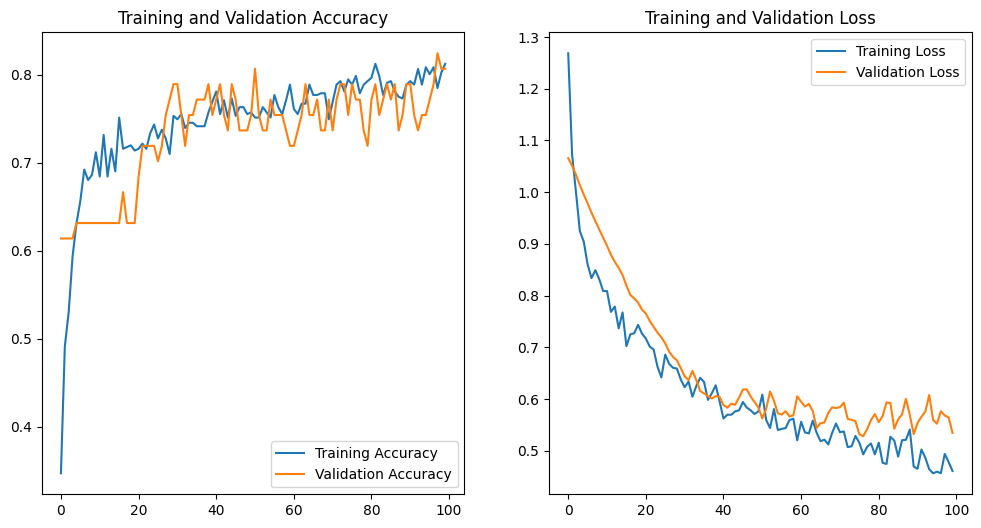

2/2 [==============================] - 0s 11ms/step - loss: 0.5346 - accuracy: 0.8070
Test Loss: 0.5345590114593506
Test Accuracy: 0.8070175647735596


In [43]:

lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.2,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=4, num_cells=16,
                       use_peephole=True,regularization=0.007)
lstm_model.train()

best architecture 

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 11s 225ms/step - loss: 1.8587 - accuracy: 0.4517 - val_loss: 1.6532 - val_accuracy: 0.5439
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 1.6299 - accuracy: 0.5049 - val_loss: 1.6347 - val_accuracy: 0.5439
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 1.6000 - accuracy: 0.5582 - val_loss: 1.6157 - val_accuracy: 0.5439
Epoch 4/100
8/8 [==============================] - 0s 36ms/step - loss: 1.4822 - accuracy: 0.5838 - val_loss: 1.5967 - val_accuracy: 0.5439
Epoch 5/100
8/8 [==============================] - 0s 52ms/step - loss: 1.4699 - accuracy: 0.6213 - val_loss: 1.5780 - val_accuracy: 0.5439
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 1.4099 - accuracy: 0.6489 - val_loss: 1.5589 - val_accuracy: 0.5439
Epoch 7/100
8/8 [==============================] - 0s 28ms/ste

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


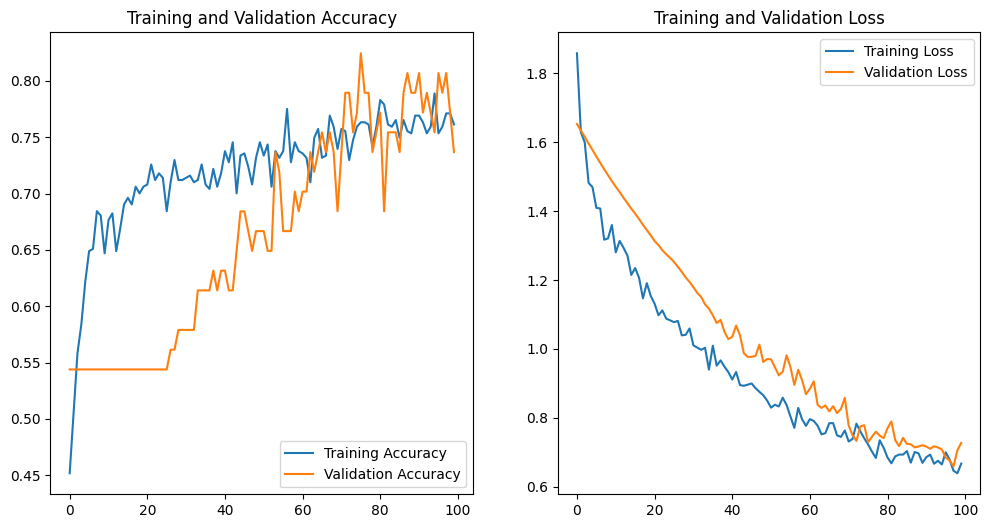

2/2 [==============================] - 0s 10ms/step - loss: 0.7271 - accuracy: 0.7368
Test Loss: 0.7271196246147156
Test Accuracy: 0.7368420958518982


In [49]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.2,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=4, num_cells=16,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

Achieving the best accuracy is possible with the right architecture and adjusting the droprate.

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 9s 259ms/step - loss: 2.1082 - accuracy: 0.3037 - val_loss: 1.6699 - val_accuracy: 0.5088
Epoch 2/100
8/8 [==============================] - 0s 33ms/step - loss: 1.9191 - accuracy: 0.3688 - val_loss: 1.6404 - val_accuracy: 0.5088
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 1.8033 - accuracy: 0.4004 - val_loss: 1.6143 - val_accuracy: 0.5088
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 1.6854 - accuracy: 0.4596 - val_loss: 1.5892 - val_accuracy: 0.5088
Epoch 5/100
8/8 [==============================] - 0s 31ms/step - loss: 1.6642 - accuracy: 0.4655 - val_loss: 1.5644 - val_accuracy: 0.5088
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 1.6206 - accuracy: 0.5049 - val_loss: 1.5396 - val_accuracy: 0.5088
Epoch 7/100
8/8 [==============================] - 0s 30ms/step

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


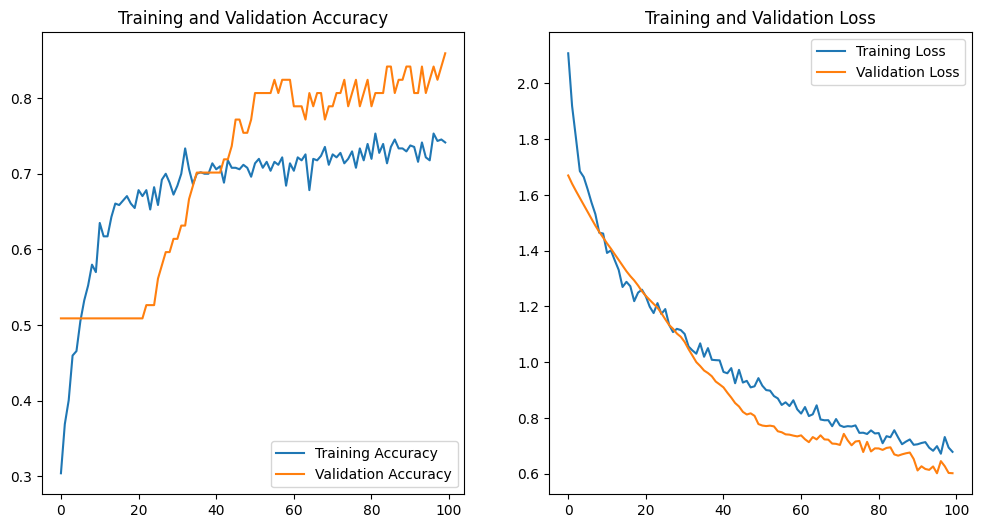

2/2 [==============================] - 0s 44ms/step - loss: 0.6020 - accuracy: 0.8596
Test Loss: 0.6019761562347412
Test Accuracy: 0.859649121761322


In [59]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=4, num_cells=16,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

model with 3 layers and 32 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 7s 193ms/step - loss: 1.9934 - accuracy: 0.4221 - val_loss: 1.8106 - val_accuracy: 0.7193
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 1.8353 - accuracy: 0.5602 - val_loss: 1.7723 - val_accuracy: 0.6491
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7081 - accuracy: 0.6036 - val_loss: 1.7346 - val_accuracy: 0.6491
Epoch 4/100
8/8 [==============================] - 0s 53ms/step - loss: 1.7209 - accuracy: 0.6154 - val_loss: 1.6967 - val_accuracy: 0.6491
Epoch 5/100
8/8 [==============================] - 0s 39ms/step - loss: 1.6428 - accuracy: 0.6272 - val_loss: 1.6606 - val_accuracy: 0.6491
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 1.5317 - accuracy: 0.6469 - val_loss: 1.6243 - val_accuracy: 0.6491
Epoch 7/100
8/8 [==============================] - 0s 30ms/step

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


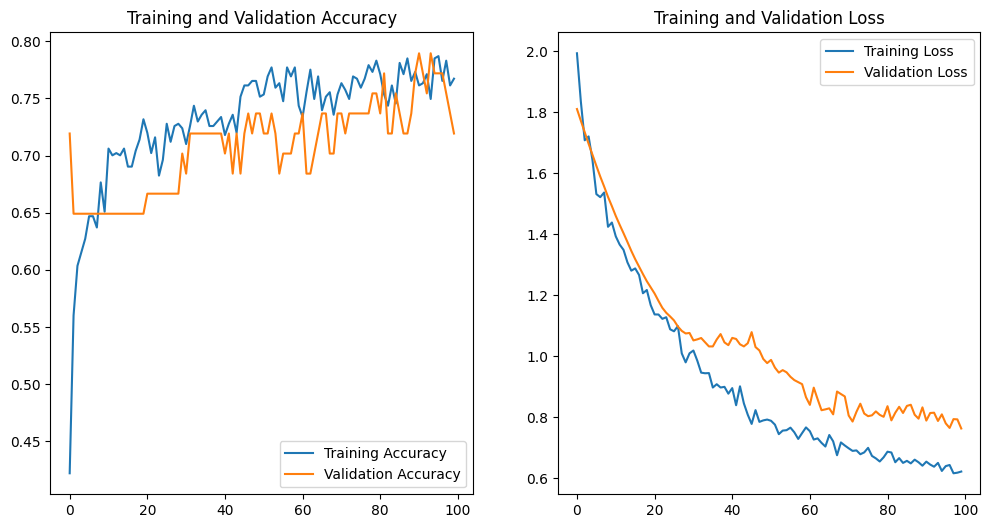

2/2 [==============================] - 0s 11ms/step - loss: 0.7634 - accuracy: 0.7193
Test Loss: 0.763425886631012
Test Accuracy: 0.719298243522644


In [52]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=3, num_cells=32,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

model with 2 layers and 32 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 4s 127ms/step - loss: 1.6202 - accuracy: 0.4083 - val_loss: 1.4630 - val_accuracy: 0.7018
Epoch 2/100
8/8 [==============================] - 0s 21ms/step - loss: 1.4844 - accuracy: 0.5247 - val_loss: 1.4290 - val_accuracy: 0.7018
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 1.4457 - accuracy: 0.5464 - val_loss: 1.4016 - val_accuracy: 0.6491
Epoch 4/100
8/8 [==============================] - 0s 19ms/step - loss: 1.3641 - accuracy: 0.5996 - val_loss: 1.3728 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 0s 19ms/step - loss: 1.2928 - accuracy: 0.6391 - val_loss: 1.3467 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 20ms/step - loss: 1.3081 - accuracy: 0.6450 - val_loss: 1.3231 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 19ms/step

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


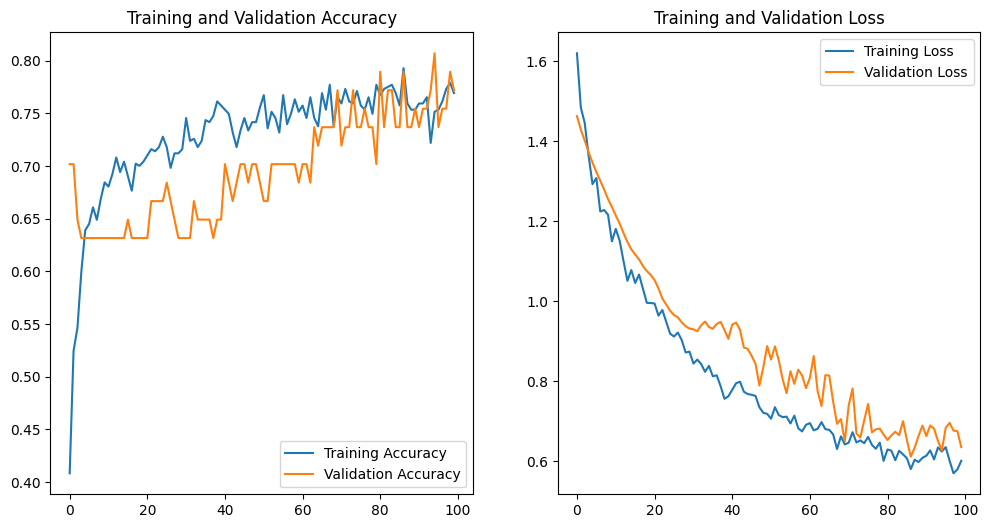

2/2 [==============================] - 0s 5ms/step - loss: 0.6347 - accuracy: 0.7719
Test Loss: 0.6347057819366455
Test Accuracy: 0.7719298005104065


In [53]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=2, num_cells=32,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

model with 2 layers and 128 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 9s 180ms/step - loss: 2.7045 - accuracy: 0.4970 - val_loss: 2.4536 - val_accuracy: 0.5965
Epoch 2/100
8/8 [==============================] - 1s 71ms/step - loss: 2.4732 - accuracy: 0.5700 - val_loss: 2.3470 - val_accuracy: 0.5965
Epoch 3/100
8/8 [==============================] - 1s 88ms/step - loss: 2.3309 - accuracy: 0.6095 - val_loss: 2.2486 - val_accuracy: 0.5965
Epoch 4/100
8/8 [==============================] - 1s 81ms/step - loss: 2.2061 - accuracy: 0.6272 - val_loss: 2.1596 - val_accuracy: 0.5965
Epoch 5/100
8/8 [==============================] - 1s 77ms/step - loss: 2.0914 - accuracy: 0.6548 - val_loss: 2.0705 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 1s 75ms/step - loss: 1.9621 - accuracy: 0.6568 - val_loss: 1.9885 - val_accuracy: 0.6140
Epoch 7/100
8/8 [==============================] - 1s 72ms/step

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


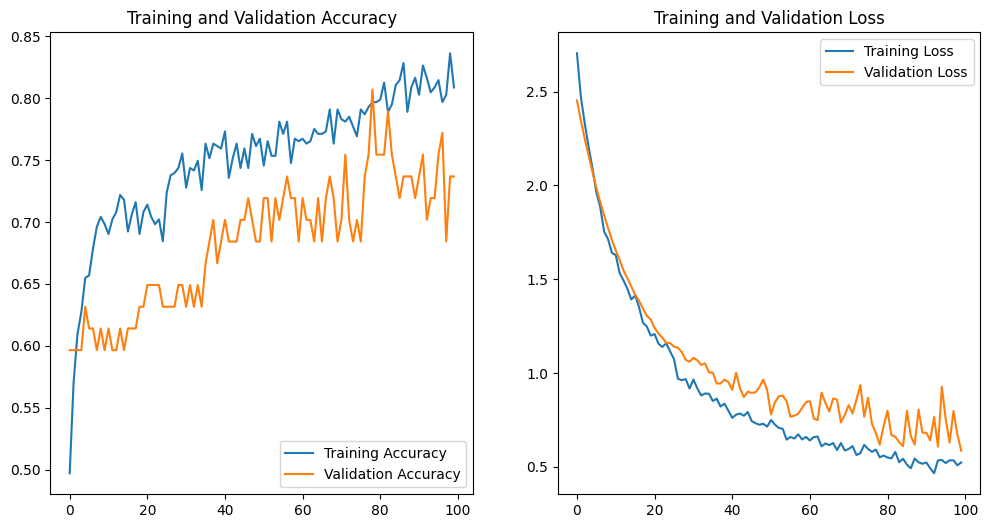

2/2 [==============================] - 0s 20ms/step - loss: 0.5856 - accuracy: 0.7368
Test Loss: 0.5856118202209473
Test Accuracy: 0.7368420958518982


In [54]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=2, num_cells=128,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

best architecture with minMaxScaler preprocessing technique

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 9s 242ms/step - loss: 2.0415 - accuracy: 0.3393 - val_loss: 1.6588 - val_accuracy: 0.5614
Epoch 2/100
8/8 [==============================] - 0s 31ms/step - loss: 1.9506 - accuracy: 0.3767 - val_loss: 1.6377 - val_accuracy: 0.5614
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 1.8696 - accuracy: 0.3905 - val_loss: 1.6158 - val_accuracy: 0.5614
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 1.8959 - accuracy: 0.3787 - val_loss: 1.5957 - val_accuracy: 0.5614
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 1.8402 - accuracy: 0.3807 - val_loss: 1.5756 - val_accuracy: 0.5614
Epoch 6/100
8/8 [==============================] - 0s 31ms/step - loss: 1.7926 - accuracy: 0.4004 - val_loss: 1.5570 - val_accuracy: 0.5614
Epoch 7/100
8/8 [==============================] - 0s 30ms/step

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


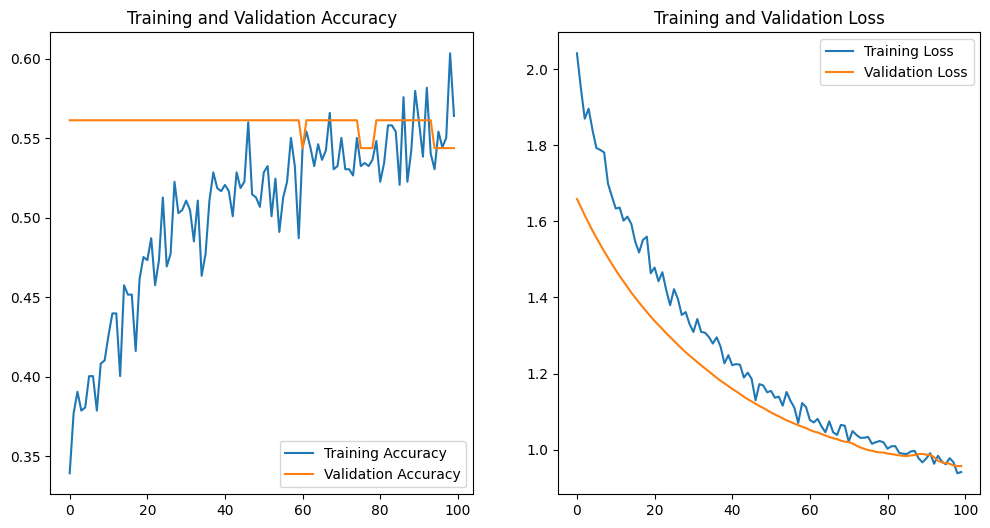

2/2 [==============================] - 0s 6ms/step - loss: 0.9569 - accuracy: 0.5439
Test Loss: 0.9568684697151184
Test Accuracy: 0.5438596606254578


In [55]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="MinMaxScaler", num_layers=4, num_cells=16,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

best architecture with RobustScaler preprocessing technique

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 10s 246ms/step - loss: 2.1509 - accuracy: 0.3136 - val_loss: 1.6387 - val_accuracy: 0.6316
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 1.9012 - accuracy: 0.3708 - val_loss: 1.6077 - val_accuracy: 0.6316
Epoch 3/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7751 - accuracy: 0.4694 - val_loss: 1.5786 - val_accuracy: 0.6316
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7396 - accuracy: 0.4813 - val_loss: 1.5500 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 1.6157 - accuracy: 0.5247 - val_loss: 1.5237 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 30ms/step - loss: 1.5312 - accuracy: 0.5503 - val_loss: 1.5007 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 28ms/ste

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


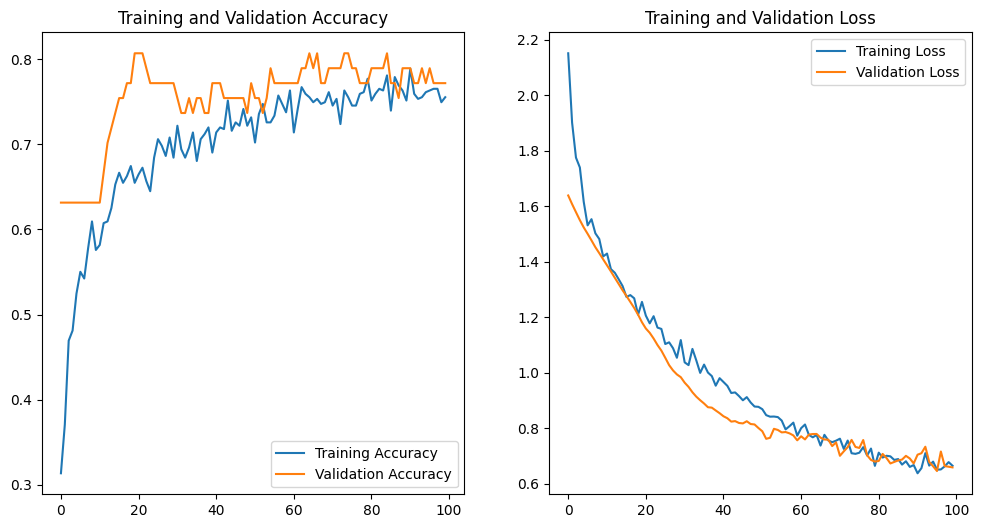

2/2 [==============================] - 0s 7ms/step - loss: 0.6594 - accuracy: 0.7719
Test Loss: 0.6594126224517822
Test Accuracy: 0.7719298005104065


In [56]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="RobustScaler", num_layers=4, num_cells=16,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

best architecture with Normalizer preprocessing technique

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100
8/8 [==============================] - 15s 240ms/step - loss: 2.1227 - accuracy: 0.3373 - val_loss: 1.6487 - val_accuracy: 0.6140
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 1.9872 - accuracy: 0.3669 - val_loss: 1.6255 - val_accuracy: 0.6316
Epoch 3/100
8/8 [==============================] - 0s 30ms/step - loss: 1.8830 - accuracy: 0.3649 - val_loss: 1.6030 - val_accuracy: 0.6316
Epoch 4/100
8/8 [==============================] - 0s 29ms/step - loss: 1.8674 - accuracy: 0.3708 - val_loss: 1.5826 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7220 - accuracy: 0.4497 - val_loss: 1.5626 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 29ms/step - loss: 1.7873 - accuracy: 0.4004 - val_loss: 1.5444 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 29ms/ste

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


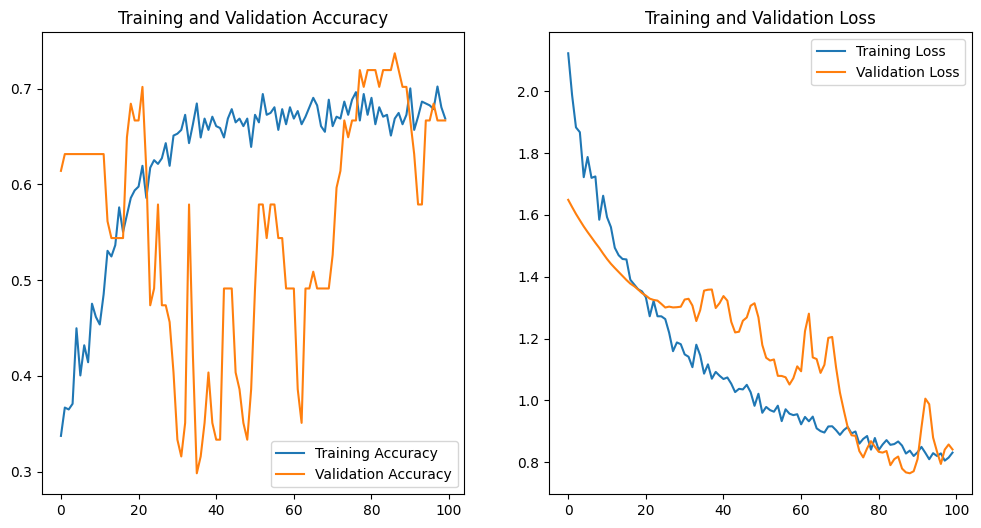

2/2 [==============================] - 0s 6ms/step - loss: 0.8412 - accuracy: 0.6667
Test Loss: 0.8412477970123291
Test Accuracy: 0.6666666865348816


In [57]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="Normalizer", num_layers=4, num_cells=16,
                       use_peephole=False,regularization=0.007)
lstm_model.train()

using peepholes and model with 3 layers and 32 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8/8 [==============================] - 10s 116ms/step - loss: 1.2290 - accuracy: 0.4970 - val_loss: 1.0350 - val_accuracy: 0.6491
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 1.1305 - accuracy: 0.5424 - val_loss: 0.9994 - val_accuracy: 0.6316
Epoch 3/100
8/8 [==============================] - 0s 38ms/step - loss: 0.9408 - accuracy: 0.6193 - val_loss: 0.9731 - val_accuracy: 0.6316
Epoch 4/100
8/8 [==============================] - 0s 34ms/step - loss: 0.9410 - accuracy: 0.6410 - val_loss: 0.9402 - val_accuracy: 0.6316
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 0.8806 - accuracy: 0.6312 - val_loss: 0.9177 - val_accuracy: 0.6316
Epoch 6/100
8/8 [==============================] - 0s 33ms/step - loss: 0.9194 - accuracy: 0.6588 - val_loss: 0.9008 - val_accuracy: 0.6316
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 0.8899 - accuracy: 0.6746 - val_loss: 0.8826 - val_accuracy: 0.6316
Epoch 8/100
8/8 [=============

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


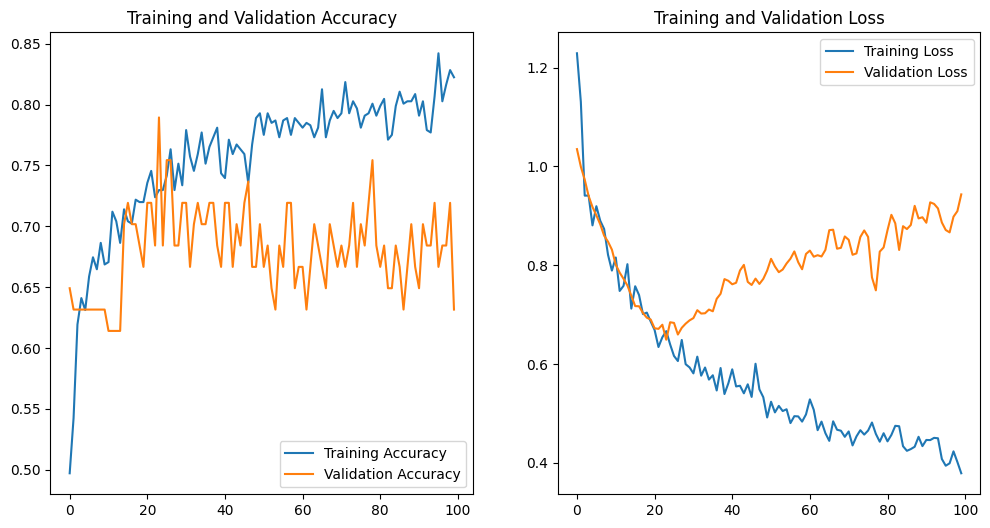

2/2 [==============================] - 0s 8ms/step - loss: 0.9433 - accuracy: 0.6316
Test Loss: 0.9433217644691467
Test Accuracy: 0.6315789222717285


In [60]:
# using peepholes 
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=3, num_cells=32,
                       use_peephole=True,regularization=0.007)
lstm_model.train()

using peepholes and model with 2 layers and 32 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8/8 [==============================] - 13s 116ms/step - loss: 1.3116 - accuracy: 0.4280 - val_loss: 1.0560 - val_accuracy: 0.5965
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 1.0839 - accuracy: 0.5523 - val_loss: 1.0245 - val_accuracy: 0.6842
Epoch 3/100
8/8 [==============================] - 0s 35ms/step - loss: 0.9855 - accuracy: 0.5917 - val_loss: 0.9977 - val_accuracy: 0.6491
Epoch 4/100
8/8 [==============================] - 0s 40ms/step - loss: 0.9252 - accuracy: 0.6272 - val_loss: 0.9735 - val_accuracy: 0.6667
Epoch 5/100
8/8 [==============================] - 0s 30ms/step - loss: 0.9067 - accuracy: 0.6292 - val_loss: 0.9470 - val_accuracy: 0.6667
Epoch 6/100
8/8 [==============================] - 0s 25ms/step - loss: 0.9401 - accuracy: 0.6450 - val_loss: 0.9295 - val_accuracy: 0.6491
Epoch 7/100
8/8 [==============================] - 0s 27ms/step - loss: 0.8164 - accuracy: 0.6765 - val_loss: 0.9151 - val_accuracy: 0.6316
Epoch 8/100
8/8 [=============

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


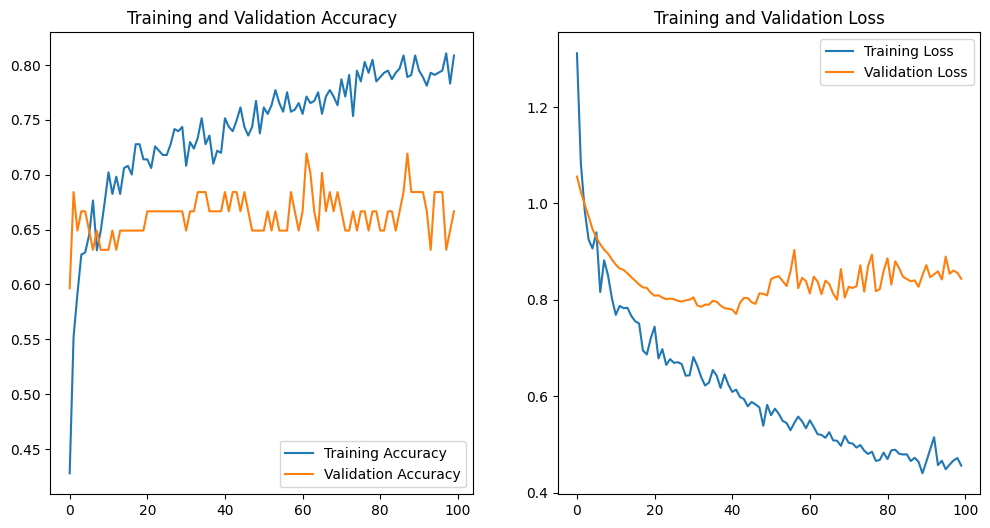

2/2 [==============================] - 0s 7ms/step - loss: 0.8439 - accuracy: 0.6667
Test Loss: 0.8439435362815857
Test Accuracy: 0.6666666865348816


In [61]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=2, num_cells=32,
                       use_peephole=True,regularization=0.007)
lstm_model.train()

using peepholes and model with 2 layers and 128 cells

X_train shape (507, 31, 3)
y_train shape (507, 1)
X_test shape (57, 31, 3)
y_test shape (57, 1)
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


8/8 [==============================] - 5s 154ms/step - loss: 1.3368 - accuracy: 0.4793 - val_loss: 1.0193 - val_accuracy: 0.7368
Epoch 2/100
8/8 [==============================] - 1s 93ms/step - loss: 1.0232 - accuracy: 0.6114 - val_loss: 0.9706 - val_accuracy: 0.7368
Epoch 3/100
8/8 [==============================] - 1s 105ms/step - loss: 0.9454 - accuracy: 0.6193 - val_loss: 0.9152 - val_accuracy: 0.7018
Epoch 4/100
8/8 [==============================] - 1s 101ms/step - loss: 0.8511 - accuracy: 0.6627 - val_loss: 0.8862 - val_accuracy: 0.7018
Epoch 5/100
8/8 [==============================] - 1s 160ms/step - loss: 0.8594 - accuracy: 0.6805 - val_loss: 0.8668 - val_accuracy: 0.7018
Epoch 6/100
8/8 [==============================] - 1s 97ms/step - loss: 0.8514 - accuracy: 0.6568 - val_loss: 0.8407 - val_accuracy: 0.6842
Epoch 7/100
8/8 [==============================] - 1s 133ms/step - loss: 0.7931 - accuracy: 0.6647 - val_loss: 0.8335 - val_accuracy: 0.7018
Epoch 8/100
8/8 [==========

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


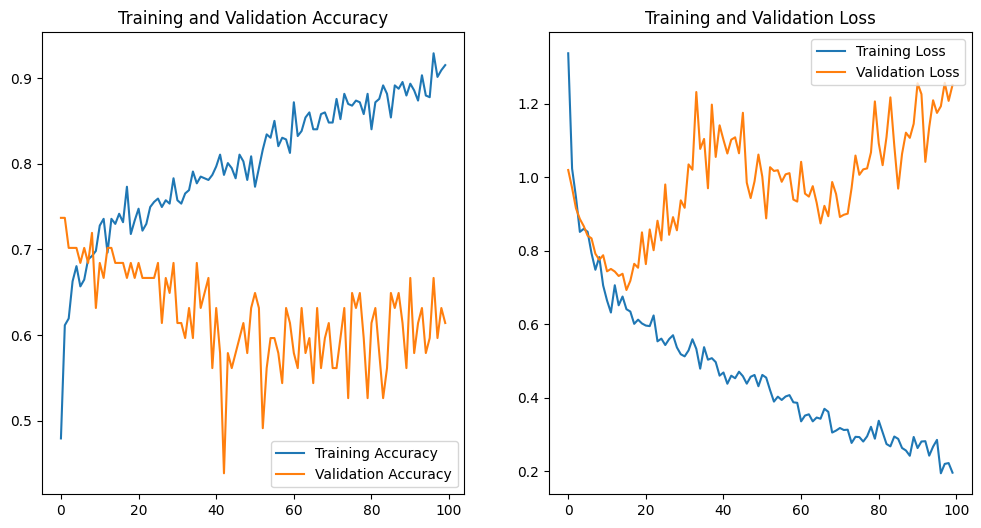

2/2 [==============================] - 0s 49ms/step - loss: 1.2505 - accuracy: 0.6140
Test Loss: 1.2505362033843994
Test Accuracy: 0.6140350699424744


In [62]:
lstm_model = LSTMModel(epochs=100, learning_rate=0.001, is_batch_normalization=True, dropout_rate=0.4,
                       data_path="/Users/yeshwanth/Documents/DL/project-2/part-2/training-validation", preprocess="StandardScaler", num_layers=2, num_cells=128,
                       use_peephole=True,regularization=0.007)
lstm_model.train()

comparison between LSTM and Peepholes

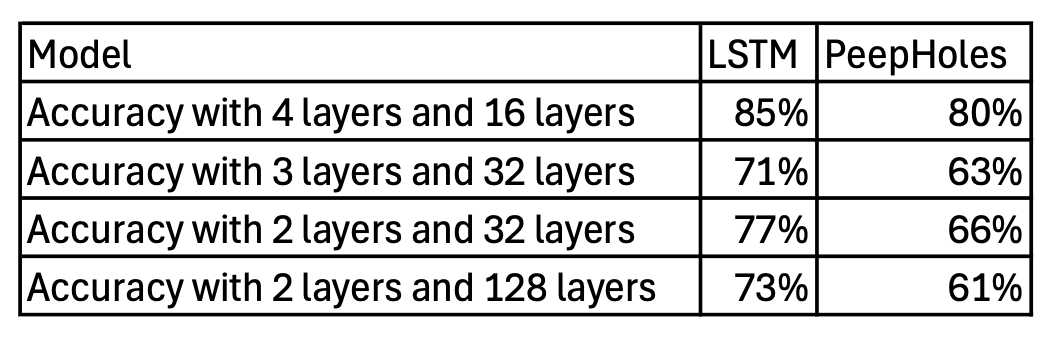